# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [1]:
import csv
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

In [2]:
X = pd.read_csv('data.csv')
y = pd.read_csv('labels.csv')
features = pd.read_csv('feature_names.csv')

In [3]:
X.sample(10)

,1.118399999999999950e-01,1.238699999999999940e-01,1.285799999999999998e-01,1.132399999999999934e-01,1.057099999999999984e-01,1.068999999999999950e-01,1.075600000000000028e-01,1.106400000000000022e-01,1.087499999999999994e-01,1.589299999999999879e-01,...,5.716099999999999515e-01,7.387000000000000233e-01,5.870900000000000007e-01,5.519800000000000262e-01,5.481099999999999861e-01,5.786900000000000377e-01,5.934500000000000330e-01,6.043600000000000083e-01,5.629399999999999959e-01,1.014399999999999968e+00
6,0.472620,0.427340,0.420380,0.407640,0.416990,0.381380,0.371680,0.368540,0.383340,0.383070,...,0.23861,0.22684,0.49098,0.72769,0.97192,0.63858,0.74988,1.15680,0.73012,0.57521
87,0.705060,0.739980,0.655360,0.670210,0.657290,0.684750,0.666670,0.672660,0.676200,0.448910,...,0.57862,0.56920,0.72510,0.38318,0.47567,0.48848,0.37624,0.42604,0.51866,1.08610
141,0.465160,0.425030,0.436470,0.737850,0.588920,0.494400,0.429410,0.392740,0.443440,0.557570,...,0.45700,0.35182,0.50970,1.53000,0.83815,0.57222,2.25390,1.75480,0.70101,0.94437
124,0.260170,0.330230,0.350310,0.139730,0.295920,0.413770,0.436450,0.425300,0.397560,0.327330,...,0.68494,0.69539,0.31051,0.41316,1.38190,0.82582,0.24282,0.44468,0.90095,0.62513
158,0.107290,0.119190,0.136600,0.073978,0.094067,0.089620,0.087399,0.091702,0.114120,0.117560,...,1.44670,1.18070,1.01980,2.54840,4.30650,1.93320,2.63540,2.89970,2.50010,1.28580
70,0.526650,0.487930,0.516260,0.642340,0.528280,0.433770,0.413770,0.478340,0.574820,0.698800,...,0.35558,0.26942,0.28182,0.47825,0.57393,0.44045,0.76310,0.70719,0.54636,0.55799
72,0.910800,0.888620,0.797310,0.829780,0.914860,0.893100,0.881890,0.847760,0.794640,0.482230,...,0.40799,0.41089,0.39806,0.39881,0.40254,0.51644,0.46453,0.58408,0.46190,0.80712
174,0.079822,0.081258,0.079273,0.083723,0.069784,0.063498,0.061792,0.059784,0.066457,0.077352,...,1.31050,1.16220,0.95190,2.32520,1.87490,1.74620,2.72400,2.71860,2.82880,1.23630
57,0.098105,0.103930,0.094465,0.107220,0.072064,0.074455,0.076142,0.082791,0.083776,0.161680,...,1.46450,0.97030,0.67079,0.81235,0.96216,0.96309,0.85684,0.93007,0.89246,2.51580
81,0.537560,0.554420,0.546150,0.447330,0.444920,0.413910,0.410300,0.371610,0.351090,0.508080,...,0.55788,0.65354,0.85064,0.62744,0.64646,0.70163,0.64235,0.69704,0.69541,0.64858


In [4]:
y.sample(10)

,0.000000000000000000e+00
79,0.0
39,0.0
9,0.0
142,1.0
151,1.0
105,1.0
35,0.0
34,0.0
162,1.0
165,1.0


In [5]:
features

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47


In [6]:
#Feature Elimination = Chi2 | Classifier = KNN

# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

In [7]:
print(X)
print(X.shape)

[[0.11184 0.12387 0.12858 ... 0.60436 0.56294 1.0144 ]
 [0.29834 0.26881 0.26239 ... 0.58386 0.46658 0.74867]
 [0.36912 0.39587 0.38999 ... 0.49383 0.62363 0.61417]
 ...
 [0.15921 0.15782 0.16968 ... 0.63907 0.62307 1.0707 ]
 [0.94111 0.95293 0.9505  ... 0.99212 0.97502 0.97734]
 [0.25397 0.2434  0.26774 ... 0.83146 0.76753 0.81081]]
(180, 432)


In [8]:
print(y)
print(y.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(180,)


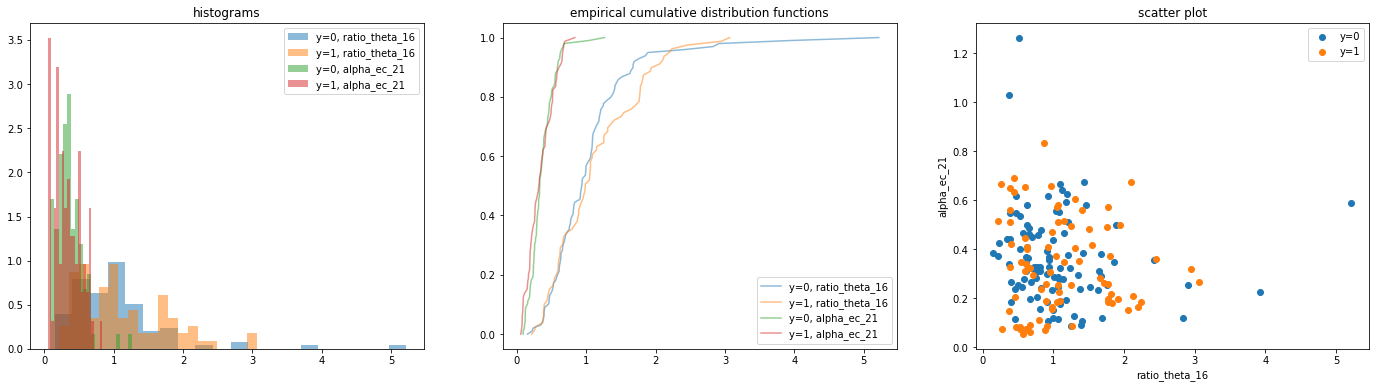

In [9]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [10]:
df=pd.DataFrame(X)
df

,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,431
0,0.111840,0.123870,0.128580,0.113240,0.105710,0.106900,0.107560,0.110640,0.108750,0.158930,...,0.57161,0.73870,0.58709,0.55198,0.54811,0.57869,0.59345,0.60436,0.56294,1.01440
1,0.298340,0.268810,0.262390,0.380090,0.343580,0.285000,0.247910,0.250330,0.260470,0.260160,...,0.35142,0.32788,0.43164,0.49603,0.40680,0.31283,0.66352,0.58386,0.46658,0.74867
2,0.369120,0.395870,0.389990,0.257720,0.405540,0.441990,0.440040,0.399470,0.315460,0.283480,...,0.61924,0.86506,1.09310,0.31759,0.36353,0.50553,0.33478,0.49383,0.62363,0.61417
3,0.761200,0.777260,0.770420,0.601610,0.701830,0.727250,0.762450,0.789040,0.729840,0.522360,...,0.23456,0.25090,0.43196,0.71301,0.53340,0.28528,0.68135,0.66315,0.25250,0.85448
4,0.167700,0.151460,0.147140,0.157280,0.149650,0.141540,0.132280,0.127600,0.143510,0.172520,...,1.82160,1.73190,1.24420,2.76220,3.00930,2.43520,2.53070,2.58470,2.00770,2.29460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.079822,0.081258,0.079273,0.083723,0.069784,0.063498,0.061792,0.059784,0.066457,0.077352,...,1.31050,1.16220,0.95190,2.32520,1.87490,1.74620,2.72400,2.71860,2.82880,1.23630
176,0.346500,0.362790,0.343660,0.277240,0.316030,0.379750,0.420140,0.452390,0.421380,0.250020,...,0.69648,0.67680,0.82459,0.37865,0.45749,0.61751,0.35155,0.48109,0.65537,0.64262
177,0.159210,0.157820,0.169680,0.178980,0.140980,0.132490,0.126600,0.130490,0.149720,0.222240,...,1.04600,0.85727,0.64390,0.87481,1.09470,0.99918,0.65529,0.63907,0.62307,1.07070
178,0.941110,0.952930,0.950500,0.726600,0.766260,0.655290,0.636660,0.645460,0.763470,0.841900,...,1.14790,0.94833,0.59572,0.80736,0.71848,0.96166,0.98636,0.99212,0.97502,0.97734


# Method 1 :- Feature Elimination Method = Chi2 | Classifier = KNN

In [11]:
#Implement Chi2 to reduce dimensions of test data
# Feature extraction
test = SelectKBest(score_func=chi2, k=22)
fit = test.fit(X, y)

# Summarize scores
np.set_printoptions(precision=3)
#print(fit.scores_)
features = fit.transform(X)

# Summarize selected features
print(features)
print(features.shape)

[[1.454 1.695 1.024 ... 0.637 0.867 0.935]
 [4.193 6.148 4.16  ... 0.902 1.027 0.979]
 [1.073 0.7   1.464 ... 0.588 0.765 0.613]
 ...
 [0.301 0.361 0.269 ... 0.586 0.588 0.844]
 [1.571 1.204 2.198 ... 0.808 0.886 1.361]
 [2.035 1.732 1.929 ... 1.16  1.105 1.074]]
(180, 22)


In [12]:
#Feature_scaling
sc_X = StandardScaler()
X = sc_X.fit_transform(features)
print (X[0])
print(X.shape)

[-0.495 -0.305 -0.336 -0.513  0.082 -0.329  0.18   0.26   0.709 -0.286
 -0.114  0.117  0.023 -0.291 -0.284 -0.23  -0.278  0.57   0.212 -0.236
  0.254  0.265]
(180, 22)


TRAIN: [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179] TEST: [0 1 2 3 4 5 6 7 8 9]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75

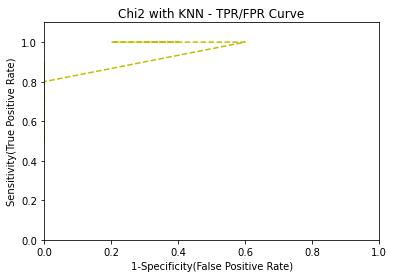


Accuracy of model: 0.7167
Sensitivity of model:  0.8889
Specificity of model :  0.8278
Chi2_KNN_ROC_AUC =  0.70625


In [13]:
#Implementing leave one out K Fold cross validation by splitting sample data in equal 18 parts
kf = KFold(n_splits=18)
kf.get_n_splits(X)

se_list = []
sp_list = []

y_test_list=[]
y_pred_list=[]
tpr_list1=[]
fpr_list1=[]
#print(kf)
accuracy_list=[]

for train_index, test_index in kf.split(X):
       
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
       
    classifier = KNeighborsClassifier(n_neighbors=11)
    classifier.fit(X_train, y_train)
    y_pred= classifier.predict(X_test) 
    
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
   
    tp, fn, fp, tn  = confusion_matrix(y_test,y_pred,labels=[0,1]).ravel()
    se = 1
    sp = 1
    if (tp+fn) != 0:
        se = tp / (tp+fn)
    if (tn+fp) != 0:
        sp = tn / (tn+fp)
        
    tpr=se    
    fpr=1-sp
               
    tpr_list1.append(tpr)  
    fpr_list1.append(fpr)
    se_list.append(se)
    sp_list.append(sp)
        
    cm=np.zeros((2,2))   
    Accuracy=classifier.score(X_test, y_test)
    accuracy_list.append(Accuracy)  

print ("tpr:",tpr_list1)
print ("fpr:",fpr_list1)
plt.plot(fpr_list1, tpr_list1,'y--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Chi2 with KNN - TPR/FPR Curve')
plt.show()   # Display   
print ("\nAccuracy of model:",round(np.mean(accuracy_list),4))
print('Sensitivity of model: ',round(np.mean(se_list),4))
print('Specificity of model : ',round(np.mean(sp_list),4))
Chi2_KNN_ROC=roc_auc_score(y_test_list,y_pred_list)
print ('Chi2_KNN_ROC_AUC = ',Chi2_KNN_ROC)

# Method 2 :- Feature Elimination Method = Chi2 | Classifier = Logistic Regression

In [14]:
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

In [15]:
#Implement Chi2 to reduce dimensions of test data
# Feature extraction
test = SelectKBest(score_func=chi2, k=22)
fit = test.fit(X, y)

# Summarize scores
np.set_printoptions(precision=3)
#print(fit.scores_)
features = fit.transform(X)

# Summarize selected features
print(features)
print(features.shape)

[[1.454 1.695 1.024 ... 0.637 0.867 0.935]
 [4.193 6.148 4.16  ... 0.902 1.027 0.979]
 [1.073 0.7   1.464 ... 0.588 0.765 0.613]
 ...
 [0.301 0.361 0.269 ... 0.586 0.588 0.844]
 [1.571 1.204 2.198 ... 0.808 0.886 1.361]
 [2.035 1.732 1.929 ... 1.16  1.105 1.074]]
(180, 22)


In [16]:
#Feature_scaling
sc_X = StandardScaler()
X = sc_X.fit_transform(features)
print (X)

[[-4.953e-01 -3.047e-01 -3.357e-01 ... -2.363e-01  2.535e-01  2.646e-01]
 [ 6.515e-01  1.757e+00  1.504e-02 ...  5.082e-01  6.498e-01  3.659e-01]
 [-6.548e-01 -7.650e-01 -2.866e-01 ... -3.730e-01 -1.051e-03 -4.876e-01]
 ...
 [-9.779e-01 -9.221e-01 -4.202e-01 ... -3.783e-01 -4.398e-01  5.063e-02]
 [-4.462e-01 -5.320e-01 -2.045e-01 ...  2.430e-01  3.008e-01  1.258e+00]
 [-2.519e-01 -2.877e-01 -2.345e-01 ...  1.231e+00  8.443e-01  5.889e-01]]


TRAIN: [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179] TEST: [0 1 2 3 4 5 6 7 8 9]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75

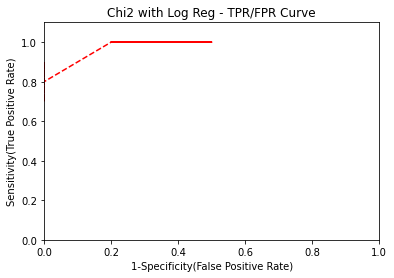


Accuracy of model: 0.7444
Sensitivity of model:  0.8889
Specificity of model :  0.8556
Chi2_log_ROC_AUC =  0.7374999999999999


In [17]:
#Implementing leave one out K Fold cross validation by splitting sample data in equal 18 parts
kf = KFold(n_splits=18)
kf.get_n_splits(X)

se_list = []
sp_list = []

y_test_list=[]
y_pred_list=[]
tpr_list2=[]
fpr_list2=[]
#print(kf)
accuracy_list=[]

for train_index, test_index in kf.split(X):
       
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
       
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred= classifier.predict(X_test)
       
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
       
    tp, fn, fp, tn  = confusion_matrix(y_test,y_pred,labels=[0,1]).ravel()
    se = 1
    sp = 1
    if (tp+fn) != 0:
        se = tp / (tp+fn)
    if (tn+fp) != 0:
        sp = tn / (tn+fp)
    
    tpr=se
    fpr=1-sp
           
    tpr_list2.append(tpr)  
    fpr_list2.append(fpr)
    se_list.append(se)
    sp_list.append(sp)        
    cm=np.zeros((2,2)) 
    Accuracy=classifier.score(X_test, y_test)
    accuracy_list.append(Accuracy)
    
print ("tpr:",tpr_list2)
print ("fpr:",fpr_list2)
plt.plot(fpr_list2, tpr_list2,'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Chi2 with Log Reg - TPR/FPR Curve')
plt.show()   # Display   
print ("\nAccuracy of model:",round(np.mean(accuracy_list),4))
print('Sensitivity of model: ',round(np.mean(se_list),4))
print('Specificity of model : ',round(np.mean(sp_list),4))
Chi2_log_ROC=roc_auc_score(y_test_list,y_pred_list)
print ('Chi2_log_ROC_AUC = ',Chi2_log_ROC)

# Method 3 :- Feature Elimination Method = Backward Feature Elimination | Classifier = Logistic Regression

In [18]:
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

In [19]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=5,step=1,verbose=0)
fit = rfe.fit(X, y)
features=fit.transform(X)
print(features.shape)

#print("Num Features: %s" % (fit.n_features_))
#print("Selected Features: %s" % (fit.support_))
#print("Feature Ranking: %s" % (fit.ranking_))

(180, 5)


In [20]:
sc_X = StandardScaler()
X = sc_X.fit_transform(features)
print (X)

[[ 1.169e+00  2.123e-01  8.308e-01 -2.363e-01 -3.258e-01]
 [ 1.055e+00  2.914e-01  5.455e-03  5.082e-01  2.564e+00]
 [-4.834e-01 -4.716e-01 -5.879e-01 -3.730e-01 -1.012e+00]
 [-1.205e+00 -6.361e-01 -6.337e-01 -1.114e+00 -3.382e-01]
 [-1.170e-01 -3.202e-01 -5.899e-01 -4.385e-01 -1.384e+00]
 [ 4.422e-01  2.402e-01 -9.818e-01 -5.772e-01 -1.026e-01]
 [ 1.210e+00  5.082e-01 -6.979e-01 -4.469e-01 -4.235e-01]
 [-1.448e+00 -6.694e-01 -1.079e+00 -8.996e-01 -1.173e+00]
 [-1.169e+00 -7.064e-01 -1.133e+00 -1.180e+00 -1.220e+00]
 [-5.465e-02 -8.506e-02 -5.818e-02  1.599e-01  8.491e-01]
 [-7.710e-01 -5.578e-01 -6.746e-01 -3.480e-01 -4.233e-01]
 [-2.353e-01 -2.532e-01 -1.299e-02 -6.044e-02 -2.394e-01]
 [ 5.654e-02 -2.126e-01  1.113e-02 -7.087e-01  1.079e-02]
 [-1.260e+00 -6.269e-01 -1.148e+00 -1.314e+00 -9.322e-01]
 [-8.546e-01 -5.611e-01 -8.724e-01 -8.676e-01 -1.124e+00]
 [ 2.439e+00  7.680e-01 -2.331e-01 -7.235e-01  1.683e+00]
 [ 1.384e+00  4.642e-01  3.857e-01  2.142e+00  3.839e-01]
 [-8.145e-01 -

TRAIN: [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179] TEST: [0 1 2 3 4 5 6 7 8 9]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179] TEST: [120 121 122 123 124 125 126 127 128 129]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60

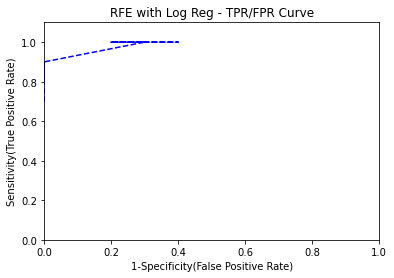


Accuracy of model: 0.7944
Sensitivity of model:  0.9167
Specificity of model :  0.8778
RFE_LOGREG_ROC_AUC =  0.7875000000000001


In [21]:
#Implementing leave one out K Fold cross validation by splitting sample data in equal 18 parts
kf = KFold(n_splits=18)
kf.get_n_splits(X)

se_list = []
sp_list = []

y_test_list=[]
y_pred_list=[]
tpr_list3=[]
fpr_list3=[]
#print(kf)
accuracy_list=[]

for train_index, test_index in kf.split(X):
       
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
       
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred= classifier.predict(X_test)
        
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    
   
    tp, fn, fp, tn  = confusion_matrix(y_test,y_pred,labels=[0,1]).ravel()
    se = 1
    sp = 1
    if (tp+fn) != 0:
        se = tp / (tp+fn)
    if (tn+fp) != 0:
        sp = tn / (tn+fp)
    
    tpr=se
    fpr=1-sp
           
    tpr_list3.append(tpr)  
    fpr_list3.append(fpr)
    se_list.append(se)
    sp_list.append(sp)        
    cm=np.zeros((2,2))   
    Accuracy=classifier.score(X_test, y_test)
    accuracy_list.append(Accuracy)
    
print ("tpr:",tpr_list3)
print ("fpr:",fpr_list3)    
plt.plot(fpr_list3, tpr_list3,'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('RFE with Log Reg - TPR/FPR Curve')
plt.show()   # Display       
print ("\nAccuracy of model:",round(np.mean(accuracy_list),4))
print('Sensitivity of model: ',round(np.mean(se_list),4))
print('Specificity of model : ',round(np.mean(sp_list),4))
rfe_logreg_roc=roc_auc_score(y_test_list,y_pred_list)
print ('RFE_LOGREG_ROC_AUC = ',rfe_logreg_roc)

# Method 4 :- Feature Elimination Method = PCA | Classifier = K Nearest Neighbours

In [22]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

In [23]:
#Implement Principal Component Analysis to reduce dimensions of test data
pca = PCA(0.99)
pca.fit(X)
pca_data = pca.transform(X)

print (pca_data)
print(pca_data.shape)

[[ -6.324  -0.508  -2.346 ...  -0.187  -0.291   0.302]
 [ 13.397 -11.727   0.79  ...  -0.135  -0.38   -0.065]
 [ -7.316   0.771  -4.085 ...  -0.466  -0.337  -0.48 ]
 ...
 [-13.825   3.699  -1.968 ...   0.149   0.194   0.539]
 [ -4.586  -0.053  -1.046 ...  -0.547   0.466   0.411]
 [ -4.672   0.74   -0.885 ...  -0.202  -0.356  -0.184]]
(180, 43)


In [24]:
#Feature_scaling
sc_X = StandardScaler()
X = sc_X.fit_transform(pca_data)
print (X)

[[-0.404 -0.073 -0.631 ... -0.398 -0.653  0.719]
 [ 0.855 -1.68   0.212 ... -0.288 -0.853 -0.155]
 [-0.467  0.11  -1.098 ... -0.991 -0.756 -1.14 ]
 ...
 [-0.883  0.53  -0.529 ...  0.316  0.435  1.282]
 [-0.293 -0.008 -0.281 ... -1.164  1.045  0.977]
 [-0.298  0.106 -0.238 ... -0.43  -0.797 -0.437]]


TRAIN: [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179] TEST: [0 1 2 3 4 5 6 7 8 9]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 170 171
 172 173 174 175 176 177 178 179] TEST: [160 161 162 163 164 165 166 167 168 169]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60

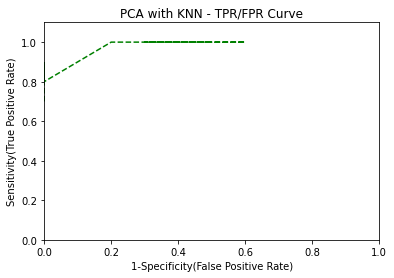


Accuracy of model: 0.7389
Sensitivity of model:  0.9056
Specificity of model :  0.8333
PCA_KNN_ROC_AUC: 0.7275


In [25]:
#Implementing leave one out K Fold cross validation by splitting sample data in equal 18 parts
kf = KFold(n_splits=18)
kf.get_n_splits(X)

se_list = []
sp_list = []

y_test_list=[]
y_pred_list=[]

tpr_list4=[]
fpr_list4=[]
#print(kf)
accuracy_list=[]

for train_index, test_index in kf.split(X):
       
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
       
    classifier = KNeighborsClassifier(n_neighbors=11)
    classifier.fit(X_train, y_train)
    y_pred= classifier.predict(X_test)
    
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
      
   
    tp, fn, fp, tn  = confusion_matrix(y_test,y_pred,labels=[0,1]).ravel()
    se = 1
    sp = 1
    if (tp+fn) != 0:
        se = tp / (tp+fn)
                        
    if (tn+fp) != 0:
        sp = tn / (tn+fp)         
        
    tpr=se
    fpr=1-sp
            
    tpr_list4.append(tpr)  
    fpr_list4.append(fpr)
    se_list.append(se)
    sp_list.append(sp)
    
       
    cm=np.zeros((2,2))
    Accuracy=classifier.score(X_test, y_test)
    accuracy_list.append(Accuracy)
    
print ("tpr:",tpr_list4)
print ("fpr:",fpr_list4)
plt.plot(fpr_list4, tpr_list4,'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('PCA with KNN - TPR/FPR Curve')
plt.show()   # Display    


print ("\nAccuracy of model:",round(np.mean(accuracy_list),4))
print('Sensitivity of model: ',round(np.mean(se_list),4))
print('Specificity of model : ',round(np.mean(sp_list),4))
AUC_KNN_PCA=roc_auc_score(y_test_list,y_pred_list)
print ("PCA_KNN_ROC_AUC:",AUC_KNN_PCA)

## Observations

From the experiment and testing results obtained different methods, we can see that Logistic
Regression Classifier with Backward Feature Elimination feature elimination technique has
produced the best accuracy rate (0.7944), sensitivity (0.9167), specificity (0.8778) and also
the ROC AUC score (0.7875). However, in method, 2 we used same classifier but with a
different dimension reduction technique (Chi2) which lead us to much lower accuracy score
(0.7444). Likewise, we used a specific feature elimination method (Chi2) with two different
classifiers in method 1 and method 2. This time Chi2 feature elimination method gave better
accuracy rate when combined with Logistic Regression, rather than K nearest Neighbour
classifier. From this observation, it was clearly seen that some feature elimination method
produces the best results when combined with a specific classifier.


Overall, the tests might have provided satisfactory results but it is still far from an ideal
Method which will be able to give nearly accurate predictions (more than 95% accuracy).
So, the right combination of classification along with the ideal feature reduction techniques
can get us near to the ideal system. We believe that the methods which we have
used has good scope to be improved in order to more accurately predict which patients later
develops Central Neuropathic Pain (CNP).